# Capstone III Preprocessing and Training Data Development

In this section we prepare our cleaned data for modeling. With this data set we have, in a sense, two sets of explanatory variables that may explain our target variable: time (how the room temperature changes over time), and the rest of the measurement data (how does co2/light/precipatation affect the room temperature). A SARIMAX model will be able to handle both sets of explanatory variables at once. How a SARIMAX model handles the exogenous variables may require some preprocessing. We may also try other kinds of non time dependent models that require some preprocessing. In this section of the project we do the following:

- Remove outliers in the CO2 columns
- Bin the sun dusk and rain columns into fewer categories
- Create our training and testing split
- Scale the data with standard scaling

### Section 1: Loading and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../Data/train_cleaned.csv', parse_dates = ['date_time'], index_col = 'date_time')

In [3]:
df.index = pd.date_range(start=df.index[0], end=df.index[-1], freq='15min')

In [4]:
df.head()

,co2_dining_room,co2_room,relative_humidity_dining_room,relative_humidity_room,lighting_dining_room,lighting_room,rain,sun_dusk,wind,sun_light_in_west_facade,sun_light_in_east_facade,sun_light_in_south_facade,sun_irradiance,outdoor_relative_humidity,indoor_temperature_room
2012-03-13 11:45:00,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,623.360,1.42625,9690.24,12604.20,95436.8,758.880,48.3750,17.8275
2012-03-13 12:00:00,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.00,10787.20,95436.8,762.069,47.8080,18.1207
2012-03-13 12:15:00,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,622.656,1.89133,13960.50,9669.63,95398.6,766.251,47.4320,18.4367
2012-03-13 12:30:00,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,622.571,1.82800,18511.20,9648.13,95360.3,766.037,47.0240,18.7513
2012-03-13 12:45:00,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,622.400,2.36071,26349.00,9208.32,95354.9,762.743,45.4743,19.0414


### Section 2: Feature Engineering

### 2.1 CO2 Columns

In [5]:
df['co2_dining_room'].describe()

count    2764.000000
mean      208.479123
std        27.032686
min       187.339000
25%       200.893250
50%       207.045500
75%       211.245500
max       594.389000
Name: co2_dining_room, dtype: float64

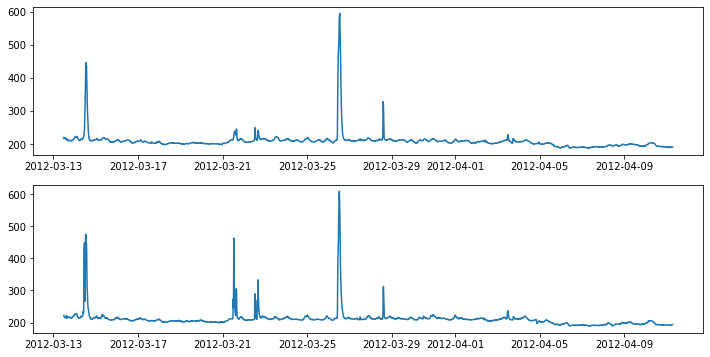

In [6]:
# View the CO2 columns again
fig = plt.figure(figsize = (12, 6))
plt.subplot(2, 1, 1)
plt.plot(df['co2_dining_room'])

plt.subplot(2, 1, 2)
plt.plot(df['co2_room'])

plt.show()

In [7]:
# Function to obtain standard outlier value
def outlier_value(column):
    standard_outlier_range = 1.5 * (column.quantile(q = 0.75) - column.quantile(q = 0.25))
    standard_outlier = standard_outlier_range + column.quantile(q = 0.75)
    return standard_outlier

In [8]:
standard_outlier = outlier_value(df['co2_dining_room'])
standard_outlier

226.77387499999998

In [9]:
# Check % of data above standard outlier
percent_above = len(df[df['co2_dining_room'] > standard_outlier]) / len(df) * 100
print(np.round(percent_above, 2), 'percent of the data is above', np.round(standard_outlier, 2))

2.68 percent of the data is above 226.77


In [10]:
# Replace all values in the column above the standard outlier with the standard outlier
df['co2_dining_room'].where(df['co2_dining_room'] <= standard_outlier, standard_outlier, inplace=True)

In [11]:
# And now for the other CO2 column
standard_outlier = outlier_value(df['co2_room'])
percent_above = len(df[df['co2_room'] > standard_outlier]) / len(df) * 100
print(np.round(percent_above, 2), 'percent of the data is above', np.round(standard_outlier, 2))

3.22 percent of the data is above 229.02


In [12]:
# Replace all values in the column above the standard outlier with the standard outlier
df['co2_room'].where(df['co2_room'] <= standard_outlier, standard_outlier, inplace=True)

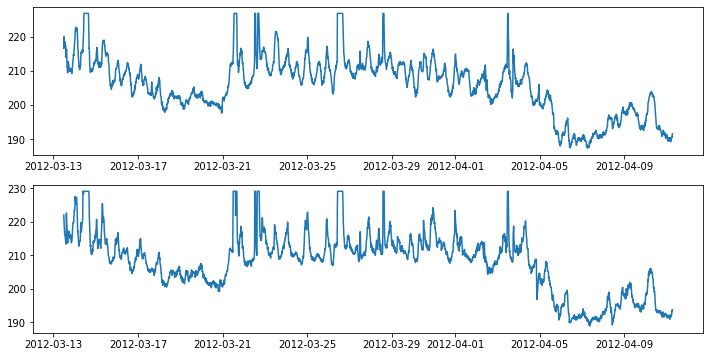

In [13]:
# Check our work
fig = plt.figure(figsize = (12, 6))
plt.subplot(2, 1, 1)
plt.plot(df['co2_dining_room'])

plt.subplot(2, 1, 2)
plt.plot(df['co2_room'])

plt.show()

### 2.2 Rain

Rain was described as the proportion of the last 15 minutes where rain was detected. Therefore, the values should be between 0 and 1.

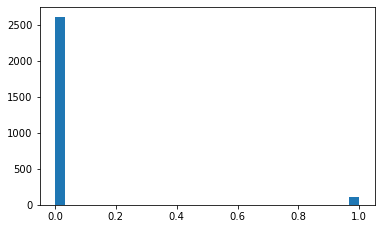

In [14]:
# View the rain column again
fig = plt.figure(figsize = (6, 8))
plt.subplot(2, 1, 1)
plt.hist(df['rain'], bins = 30)
plt.show()

In [15]:
df['rain'].describe()

count    2764.000000
mean        0.047033
std         0.206705
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: rain, dtype: float64

In [16]:
df['rain'].unique()

array([0.       , 0.8      , 1.       , 0.933333 , 0.266667 , 0.533333 ,
       0.733333 , 0.866667 , 0.0666667, 0.666667 , 0.4      , 0.333333 ,
       0.133333 , 0.6      , 0.466667 ])

In [17]:
# If the value is above 0.5, count it as rain. otherwise count it as none
for i in df['rain']:
    if i < 0.5:
        df['rain'].replace(to_replace = i, value = 'none', inplace=True)
    else:
        df['rain'].replace(to_replace = i, value = 'rain', inplace=True)

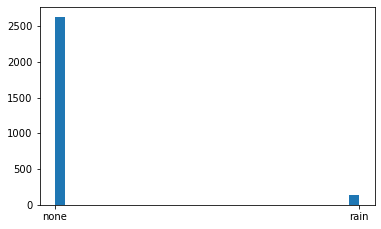

In [18]:
# Check our work
fig = plt.figure(figsize = (6, 8))
plt.subplot(2, 1, 1)
plt.hist(df['rain'], bins = 30)
plt.show()

### 2.3 Sun Dusk

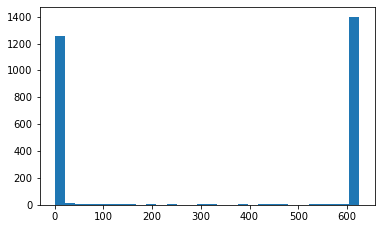

In [19]:
# View the sun dusk column again
fig = plt.figure(figsize = (6, 8))
plt.subplot(2, 1, 1)
plt.hist(df['sun_dusk'], bins = 30)
plt.show()

In [20]:
df['sun_dusk'].describe()

count    2764.000000
mean      325.369289
std       305.062614
min         0.606667
25%         0.650000
50%       611.797000
75%       619.210750
max       624.960000
Name: sun_dusk, dtype: float64

In [21]:
# Replace values with sun dusk, partial dusk, no dusk
for i in df['sun_dusk']:
    if i < 100:
        df['sun_dusk'].replace(to_replace = i, value = 'none', inplace=True)
    elif 100 <= i < 600:
        df['sun_dusk'].replace(to_replace = i, value = 'partial', inplace=True)
    else:
        df['sun_dusk'].replace(to_replace = i, value = 'full', inplace=True)

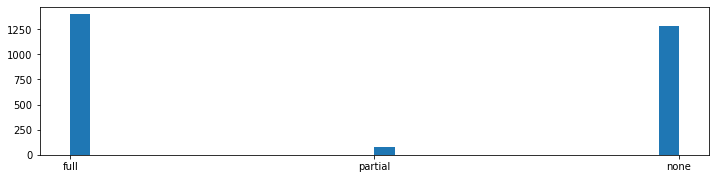

In [22]:
fig = plt.figure(figsize = (12, 6))
plt.subplot(2, 1, 1)
plt.hist(df['sun_dusk'], bins = 30)
plt.show()

### 2.4 OneHot Encoding

We will use pandas to OneHot encode our newly created categorical columns

In [23]:
df = pd.get_dummies(df, prefix=['rain', 'sun_dusk'])
df.head()

,co2_dining_room,co2_room,relative_humidity_dining_room,relative_humidity_room,lighting_dining_room,lighting_room,wind,sun_light_in_west_facade,sun_light_in_east_facade,sun_light_in_south_facade,sun_irradiance,outdoor_relative_humidity,indoor_temperature_room,rain_none,rain_rain,sun_dusk_full,sun_dusk_none,sun_dusk_partial
2012-03-13 11:45:00,216.560,221.920,39.9125,42.4150,81.6650,113.520,1.42625,9690.24,12604.20,95436.8,758.880,48.3750,17.8275,1,0,1,0,0
2012-03-13 12:00:00,219.947,220.363,39.9267,42.2453,81.7413,113.605,1.59200,11022.00,10787.20,95436.8,762.069,47.8080,18.1207,1,0,1,0,0
2012-03-13 12:15:00,219.403,218.933,39.7720,42.2267,81.4240,113.600,1.89133,13960.50,9669.63,95398.6,766.251,47.4320,18.4367,1,0,1,0,0
2012-03-13 12:30:00,218.613,217.045,39.7760,42.0987,81.5013,113.344,1.82800,18511.20,9648.13,95360.3,766.037,47.0240,18.7513,1,0,1,0,0
2012-03-13 12:45:00,217.714,216.080,39.7757,42.0686,81.4657,113.034,2.36071,26349.00,9208.32,95354.9,762.743,45.4743,19.0414,1,0,1,0,0


### Section 3: Splitting and Scaling

Train/test splits for a time series require that the data not be shuffled, and thus some extra care needs to be taken when splitting your data.

In [24]:
# Make 80/20 train/test split
split= int(len(df) * 0.8) 
train, test = df[0:split], df[split:len(df)]
train.shape, test.shape

((2211, 18), (553, 18))

In [25]:
# We only wish to scale the independent variables
X_train, y_train = train.drop(columns = 'indoor_temperature_room'), train['indoor_temperature_room']
X_test, y_test = test.drop(columns = 'indoor_temperature_room'), test['indoor_temperature_room']

In [26]:
# Scale the independent variables
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Change train and test sets back into dataframes for ease of use
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index = X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index = X_test.index)
X_train_scaled_df.head()

,co2_dining_room,co2_room,relative_humidity_dining_room,relative_humidity_room,lighting_dining_room,lighting_room,wind,sun_light_in_west_facade,sun_light_in_east_facade,sun_light_in_south_facade,sun_irradiance,outdoor_relative_humidity,rain_none,rain_rain,sun_dusk_full,sun_dusk_none,sun_dusk_partial
2012-03-13 11:45:00,1.259658,1.715107,-0.674522,-0.591184,2.293957,1.696829,0.361028,-0.188425,0.005900,2.125555,1.871279,-0.635709,0.235308,-0.235308,0.988756,-0.931342,-0.175412
2012-03-13 12:00:00,1.822433,1.462093,-0.672419,-0.612898,2.297159,1.698815,0.510874,-0.136147,-0.076794,2.125555,1.882173,-0.679815,0.235308,-0.235308,0.988756,-0.931342,-0.175412
2012-03-13 12:15:00,1.732044,1.229717,-0.695332,-0.615278,2.283843,1.698698,0.781484,-0.020797,-0.127657,2.124431,1.896460,-0.709064,0.235308,-0.235308,0.988756,-0.931342,-0.175412
2012-03-13 12:30:00,1.600779,0.922915,-0.694740,-0.631657,2.287087,1.692718,0.724231,0.157841,-0.128635,2.123304,1.895729,-0.740802,0.235308,-0.235308,0.988756,-0.931342,-0.175412
2012-03-13 12:45:00,1.451404,0.766102,-0.694784,-0.635509,2.285593,1.685475,1.205828,0.465513,-0.148652,2.123145,1.884476,-0.861350,0.235308,-0.235308,0.988756,-0.931342,-0.175412


In [28]:
# Add back on the y_values
X_train_scaled_df['indoor_temperature_room'] = y_train
X_test_scaled_df['indoor_temperature_room'] = y_test
X_test_scaled_df.head()

,co2_dining_room,co2_room,relative_humidity_dining_room,relative_humidity_room,lighting_dining_room,lighting_room,wind,sun_light_in_west_facade,sun_light_in_east_facade,sun_light_in_south_facade,sun_irradiance,outdoor_relative_humidity,rain_none,rain_rain,sun_dusk_full,sun_dusk_none,sun_dusk_partial,indoor_temperature_room
2012-04-05 12:30:00,-1.220738,-1.767126,1.679070,1.397576,1.869218,2.051067,2.068257,0.559222,0.488807,1.387201,2.094765,0.581603,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.1560
2012-04-05 12:45:00,-1.327078,-1.775901,1.675900,1.326943,2.332524,2.334635,2.222543,1.030489,0.438598,1.766622,2.607617,0.577456,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.3400
2012-04-05 13:00:00,-1.321761,-1.848702,1.697229,1.507108,0.944063,1.419546,1.904317,0.685870,0.309941,0.711389,1.426092,0.435150,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.5040
2012-04-05 13:15:00,-1.410323,-1.916302,1.740286,1.558982,-0.050365,0.393168,1.888044,0.263852,0.243795,0.082534,0.611519,0.426026,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.5693
2012-04-05 13:30:00,-1.449370,-2.028915,1.789268,1.523487,0.173063,0.955724,1.732547,0.308552,0.318111,0.041121,0.666906,0.468343,0.235308,-0.235308,0.988756,-0.931342,-0.175412,21.5840


In [29]:
# And save our work to use in the modeling stage
X_train_scaled_df.to_csv('../Data/train_scaled_df.csv')
X_test_scaled_df.to_csv('../Data/test_scaled_df.csv')